# Generative Adversarial Network (GANs)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime, os

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# setup logs
log_dir = os.path.abspath('logs')
log_writer = tf.summary.create_file_writer(log_dir)
print(log_dir)

%load_ext tensorboard

D:\Projects\Jupyter\logs


In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

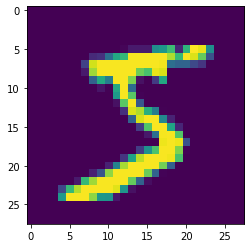

In [5]:
plt.imshow(train_images[0])

In [6]:
# reshape images
train_images = train_images.reshape(train_images.shape[0],28,28,1)

In [7]:
# normalize images
train_images = (train_images-127.5)/127.5

In [8]:
BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Discriminator Model

In [9]:
def build_discriminator_model():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(7, (3,3), padding='same', input_shape=(28,28,1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

In [10]:
model_discriminator = build_discriminator_model()

In [11]:
model_discriminator(np.random.rand(1,28,28,1).astype("float32"))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.08098321]], dtype=float32)>

In [12]:
discriminator_optimizer = tf.optimizers.Adam(1e-3)

In [13]:
def get_discriminator_loss(real_predictions, fake_predictions):
    real_predictions = tf.sigmoid(real_predictions)
    fake_predictions = tf.sigmoid(fake_predictions)
    real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
    fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions)
    return fake_loss + real_loss

## Generator

In [14]:
def build_generator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(7*7*256, input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Reshape((7,7,256)),
        tf.keras.layers.Conv2DTranspose(128, (3,3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(1, (3,3), strides=(2,2), padding='same')
    ])
    
    return model

In [15]:
model_generator = build_generator_model()

In [16]:
generator_optimizer = tf.optimizers.Adam(1e-4)

In [17]:
def get_generator_loss(fake_predictions):
    fake_predictions = tf.sigmoid(fake_predictions)
    fake_loss = tf.losses.binary_crossentropy(tf.ones_like(fake_predictions), fake_predictions)
    return fake_loss

## Training

In [18]:
def train_step(images):
    fake_image_noise = np.random.randn(BATCH_SIZE, 100).astype('float32')
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = model_generator(fake_image_noise)
        
        real_output = model_discriminator(images)
        fake_output = model_discriminator(generated_images)
        
        gen_loss = get_generator_loss(fake_output)
        disc_loss = get_discriminator_loss(real_output, fake_output)
        
        gradients_of_generator = gen_tape.gradient(gen_loss, model_generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, model_discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(gradients_of_generator, model_generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, model_discriminator.trainable_variables))
        
        return generated_images, np.mean(gen_loss), np.mean(disc_loss)

In [19]:
def train(dataset, epochs, log_writer):
    iterations_count = 0
    
    with log_writer.as_default():
        for _ in range(epochs):
            for images in dataset:
                iterations_count += 1
                images = tf.cast(images, tf.dtypes.float32)

                generated_images, generator_loss, discriminator_loss = train_step(images)
                
                step = tf.cast(iterations_count, tf.int64)

                tf.summary.scalar('Generator Loss', generator_loss, step=step)
                tf.summary.scalar('Discriminator Loss', discriminator_loss, step=step)
                
                tf.summary.image('Generated', tf.cast(255 * (generated_images + 1.0) / 2.0, tf.uint8), step=step)

                log_writer.flush()

In [28]:
# show logs
%tensorboard --logdir log_dir

Reusing TensorBoard on port 6006 (pid 5720), started 14:04:41 ago. (Use '!kill 5720' to kill it.)

In [21]:
train(train_dataset, 5, log_writer)

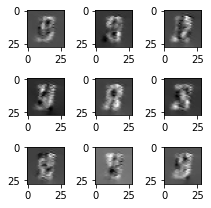

In [27]:
num_row = 3
num_col = 3

fig, axes = plt.subplots(num_row, num_col, figsize=(num_col,num_row))

for i in range(num_row * num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(tf.reshape(model_generator(np.random.randn(1,100)), (28,28)), cmap='gray')
plt.tight_layout()
plt.show()